In [28]:
from fastai.vision.all import *
import pandas as pd

In [29]:
# Download a sample of MNIST that contains images of just 3 or 7

path = untar_data(URLs.MNIST_SAMPLE)

In [30]:
path.ls()

(#3) [Path('C:/Users/joaqu/.fastai/data/mnist_sample/labels.csv'),Path('C:/Users/joaqu/.fastai/data/mnist_sample/train'),Path('C:/Users/joaqu/.fastai/data/mnist_sample/valid')]

In [31]:
#what’s inside the training set
(path/'train').ls()

(#2) [Path('C:/Users/joaqu/.fastai/data/mnist_sample/train/3'),Path('C:/Users/joaqu/.fastai/data/mnist_sample/train/7')]

In [32]:
#look in one of these folders
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('C:/Users/joaqu/.fastai/data/mnist_sample/train/3/10.png'),Path('C:/Users/joaqu/.fastai/data/mnist_sample/train/3/10000.png'),Path('C:/Users/joaqu/.fastai/data/mnist_sample/train/3/10011.png'),Path('C:/Users/joaqu/.fastai/data/mnist_sample/train/3/10031.png'),Path('C:/Users/joaqu/.fastai/data/mnist_sample/train/3/10034.png'),Path('C:/Users/joaqu/.fastai/data/mnist_sample/train/3/10042.png'),Path('C:/Users/joaqu/.fastai/data/mnist_sample/train/3/10052.png'),Path('C:/Users/joaqu/.fastai/data/mnist_sample/train/3/1007.png'),Path('C:/Users/joaqu/.fastai/data/mnist_sample/train/3/10074.png'),Path('C:/Users/joaqu/.fastai/data/mnist_sample/train/3/10091.png')...]

In [33]:
#Plot an image
im3_path = threes[2]
im3 = Image.open(im3_path)
im3

In [34]:
# Show how the image is created from the pixel values
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[3:17,5:26])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,18,93,164,254,255,254,254,254,151,0,0,0,0,0,0
3,0,0,0,13,36,151,253,253,253,253,253,253,218,239,213,10,0,0,0,0,0
4,0,0,0,89,253,253,253,245,172,82,82,82,2,148,253,150,0,0,0,0,0
5,0,0,0,89,253,252,171,54,0,0,0,0,37,177,253,188,0,0,0,0,0
6,0,0,0,17,151,51,0,0,0,0,0,40,229,253,253,147,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,83,206,237,253,253,211,8,0,0,0,0,0
8,0,0,0,0,0,0,70,143,243,251,253,253,253,181,50,0,0,0,0,0,0
9,0,0,0,0,0,4,204,253,253,253,253,253,253,106,0,0,0,0,0,0,0


In [35]:
# Create a tensor containing all of our 3s and 7s stacked together
seven_tensors = [tensor(Image.open(x)) for x in sevens]
three_tensors = [tensor(Image.open(x)) for x in threes]
len(seven_tensors), len(three_tensors)

(6265, 6131)

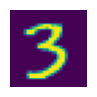

In [36]:
#Use show_image from fastai for displaying an image
show_image(three_tensors[1]);

In [37]:
# Stack tensors and scaled it to 0-1
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens.shape

torch.Size([6265, 28, 28])

<Axes: >

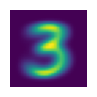

In [38]:
#Ideal 3
mean3 = stacked_threes.mean(0)
show_image(mean3)

<Axes: >

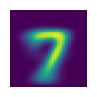

In [39]:
#Ideal 7
mean7 = stacked_sevens.mean(0)
show_image(mean7)

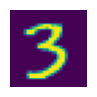

In [40]:
a_3 = stacked_threes[1]
show_image(a_3);

In [41]:
#loss to a certain mean
F.l1_loss(a_3.float(),mean3), F.l1_loss(a_3,mean7).sqrt()

(tensor(0.1114), tensor(0.3983))

In [42]:
F.mse_loss(a_3.float(),mean3), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.0408), tensor(0.3021))

In [43]:
#Do the same for validation data
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [44]:
#Define a error distance
def mnist_distance(x,y):
    return (x-y).abs().mean((-1,-2))

In [45]:
#Distance to the mean of each tensor
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260]),
 torch.Size([1010]))

In [46]:
#define a function for desicion making
def is_3(x):
    return mnist_distance(x,mean3) < mnist_distance(x,mean7)

is_3(a_3)

tensor(True)

In [47]:
#Calculate accuaracy
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = 1 - is_3(valid_7_tens).float().mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

# Using SGD

In [51]:
#Concatenate all data in one tensor
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1,28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)

train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [52]:
#Dataset in PyTorch is required to return a tuple of (x,y) when indexed.

dset = list(zip(train_x, train_y))
valid_dset = list(zip(valid_x,valid_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [53]:
#Initialize weights and bias
def init_params(size, std = 1.0):
    return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28,1))
bias = init_params(1)


In [54]:
#Define linear function
def linear1(xb):
    return xb@weights + bias

preds = linear1(train_x)
preds

tensor([[ 9.2983],
        [ 9.0767],
        [11.2921],
        ...,
        [-0.9994],
        [ 6.8896],
        [ 8.2903]], grad_fn=<AddBackward0>)

In [55]:
#For decide if an output represents a 3 or a 7, we can just check whether it’s greater than 0
corrects = (preds>0.0).float() ==train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [False],
        [False]])

In [56]:
#Accuaracy
corrects.float().mean().item()

0.5230719447135925

In [93]:
#Sigmoid function
def sigmoid(x): 
    return 1/(1+torch.exp(-x))

#Loss function
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

#Caculate gradients
def calc_grad(xb,yb,md):
    preds = md(xb)
    loss = mnist_loss(preds,yb)
    loss.backward()


In [63]:
#Initialize weights
weights = init_params((28*28,1))
bias = init_params(1)

#Dataloader
train_dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

In [64]:
# Train epoch
def train_epoch(model, lr, params):
    for xb, yb in train_dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

#Accuaracy
def batch_accuracy(xb,yb):
    preds = xb.sigmoid()
    correct = (preds>0.5)==yb
    return correct.float().mean()
        
#Put the batches together
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [65]:
#Do 1 epoch training!
lr = 0.1
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.5334

In [66]:
#Do 20 epoch training!
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.6395 0.7098 0.762 0.8008 0.8322 0.8499 0.8587 0.8729 0.8832 0.8936 0.8975 0.9038 0.9087 0.9136 0.9166 0.9185 0.921 0.9244 0.9264 0.9308 

# Optimizer

In [109]:
#Define a basic optimizer
class BasicOptim:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr
        
    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None


In [110]:
#Linear model
linear_model = nn.Linear(28*28,1)
#Create an object optimizer
opt = BasicOptim(linear_model.parameters(), 1.0)

#define simplyfied train_epoch
def train_epoch(model):
    for xb,yb in train_dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

#Train function for epochs
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [111]:
train_model(linear_model, 20)

0.4932 0.7856 0.8545 0.916 0.9351 0.9487 0.9575 0.9634 0.9653 0.9678 0.9707 0.9717 0.9746 0.9746 0.9761 0.9765 0.9775 0.978 0.978 0.9785 

In [114]:
#Using SGD

linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.5493 0.8711 0.9346 0.9546 0.9619 0.9638 0.9653 0.9673 0.9678 0.9692 0.9692 0.9702 0.9712 0.9717 0.9717 0.9717 0.9717 0.9717 0.9717 0.9717 

In [122]:
#passing in our training and validation DataLoaders
train_dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)
dls = DataLoaders(train_dl, valid_dl)

#create a Learner
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(20, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.238069,0.371607,0.543180,00:00
1,0.127905,0.187575,0.864082,00:00
2,0.086055,0.109599,0.933759,00:00
3,0.066476,0.081245,0.954367,00:00
4,0.056109,0.067490,0.963690,00:00
5,0.049965,0.059459,0.963690,00:00
6,0.045924,0.054188,0.963690,00:00
7,0.043020,0.050444,0.966143,00:00
8,0.040789,0.047632,0.966634,00:00
9,0.038991,0.045430,0.969087,00:00


# Using Neural networks and Non-Linearity

In [124]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1))

learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.329059,0.418432,0.504416,00:00
1,0.153167,0.235826,0.793916,00:00
2,0.083861,0.116477,0.916094,00:00
3,0.054519,0.078129,0.941609,00:00
4,0.041034,0.060953,0.958292,00:00
5,0.034223,0.051379,0.964671,00:00
6,0.030351,0.045380,0.965653,00:00
7,0.027859,0.041280,0.967615,00:00
8,0.026073,0.038299,0.970069,00:00
9,0.024695,0.036021,0.971050,00:00


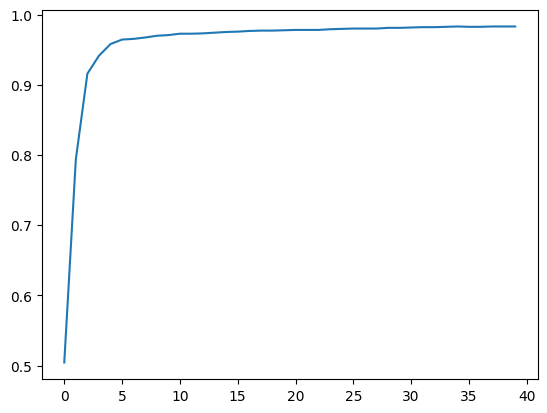

In [125]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [126]:
#Using a Resnet model

dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False, loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

c:\Users\joaqu\anaconda3\envs\pytorch_env\Lib\site-packages\fastai\vision\learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,accuracy,time
0,0.092563,0.016666,0.996565,00:32
